# XPCS&XSVS Pipeline for Mulit-SAXS Runs
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

## Control Multi-Runs Parameters

In [ ]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = False   #run waterfall analysis
run_t_ROI_Inten =  False #True  #run  ROI intensity as a function of time
run_one_time = False   #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = True#False   #run  four-time
run_xsvs= False          #run visibility analysis
att_pdf_report = False    #attach the pdf report to CHX olog
qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

good_start = 5

taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

In [3]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True# #False   #run waterfall analysis
run_t_ROI_Inten = True# False #True  #run  ROI intensity as a function of time
run_one_time = True#False   #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = True#False   #run  four-time
run_xsvs=True           #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog


qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

good_start = 5


taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [4]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


In [16]:
uid_average=  'Au50nm_2p5perc_PEG_X2_20us_Dec1_2016' #give a meaningful folder name 
data_dir_average = os.path.join( data_dir, uid_average +'/')
os.makedirs(data_dir_average, exist_ok=True)
print ( data_dir_average)

/XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/


## Load Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [5]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy' 
#mask_name = 'Dec3_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


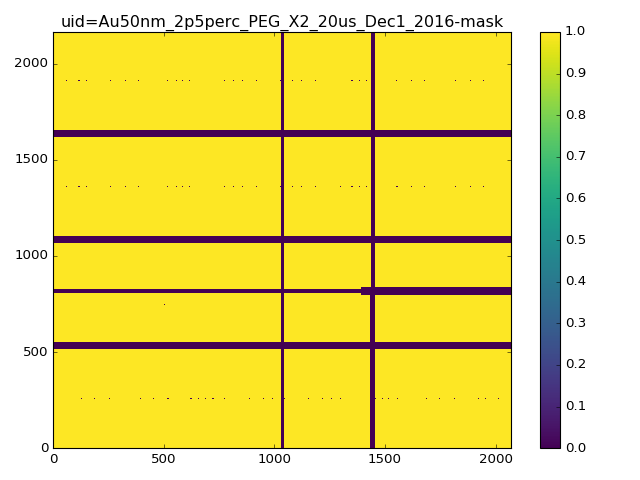

In [70]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = '%s-mask'%mask_name, reverse=True ) 
#mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = 'uid=%s-mask'%uid_average, save=True, path=data_dir_average)
mask_load=mask.copy()


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [ ]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [13]:
start_time, stop_time = '2016-12-1  14:27:10', '2016-12-1  14:32:10' 
sids, uids, fuids = find_uids(start_time, stop_time)
uid = uids[0]


Totally 10 uids are found.


In [ ]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [14]:
guids, buids = check_bad_uids( uids, mask, img_choice_N = 3 )
print( 'The good uids are: %s.\nThe length is %s.'%(guids, len(guids)) )

hdf5 path = /XF11ID/data/2016/12/01/92bf1c78-1995-4761-9e74_2280_master.h5
hdf5 path = /XF11ID/data/2016/12/01/8c3fa025-30c0-45f5-896e_2281_master.h5
hdf5 path = /XF11ID/data/2016/12/01/5e7e7c28-2166-4fe0-b984_2282_master.h5
hdf5 path = /XF11ID/data/2016/12/01/ef983494-12ef-489a-8f45_2283_master.h5
hdf5 path = /XF11ID/data/2016/12/01/0ef241ee-db8e-4588-a159_2284_master.h5
hdf5 path = /XF11ID/data/2016/12/01/6b1e3af7-16c8-4d36-8161_2285_master.h5
hdf5 path = /XF11ID/data/2016/12/01/18a1ce7c-3ead-41cb-a4ac_2286_master.h5
hdf5 path = /XF11ID/data/2016/12/01/7b7edb72-fa6a-44dd-a673_2287_master.h5
hdf5 path = /XF11ID/data/2016/12/01/91977187-ceb3-4813-96db_2288_master.h5
hdf5 path = /XF11ID/data/2016/12/01/cabc4120-72cb-48dc-8bb1_2289_master.h5
The total and bad uids number are 10 and 0, repsectively.
The good uids are: ['25f88334' 'ca87b48e' 'de453f7b' '296b1ffa' '154de8eb' '21af2295'
 '8862b3c7' '772018fb' '89297ae8' 'd2daceb0'].
The length is 10.


In [15]:
gfuids = fuids[np.array( [ np.where( uids ==  s )[0][0] for s in guids  ] )]

# Don't Change these lines below here

In [17]:
md = get_meta_data( uid )

In [18]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )
imgsa = apply_mask( imgs, mask )

hdf5 path = /XF11ID/data/2016/12/01/92bf1c78-1995-4761-9e74_2280_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 200 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [19]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> 25f88334
number of images--> 200
uid--> 25f88334-92f9-4e3b-9d34-ffee8b979960
scan_id--> 10447
start_time--> 2016-12-01 14:28:32
stop_time--> 2016-12-01 14:28:42
sample--> 50nm Au 2.5% PEG (X2)
Measurement--> sample X2 50nm Au in 2.5% PEG_fast_series_#0
acquire period--> 0.00135
exposure time--> 2e-05
det_distanc--> 4.89
beam_center_x--> 1443.0
beam_center_y--> 816.0


## Overwrite Some Metadata Due to Wrong Input

In [87]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
try:
    exposuretime= md['cam_acquire_t']     #exposure time in sec
except:    
    exposuretime= md['count_time']     #exposure time in sec
acquisition_period = md['frame_time']   #acquisition time in sec
timeperframe = acquisition_period #for g2
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image
#center = [ 2070-1381-0, 1475-4] 
setup_pargs=dict(uid=uid_average, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir_average)
print_dict( setup_pargs )

center--> [816, 1443]
timeperframe--> 0.00134
exposuretime--> 0.0013299999991431832
dpix--> 0.0750000035623
uid--> Au50nm_2p5perc_PEG_X2_20us_Dec1_2016
path--> /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/
lambda_--> 1.28481
Ldet--> 4889.99986649


# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [72]:
img_choice_N = 10
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


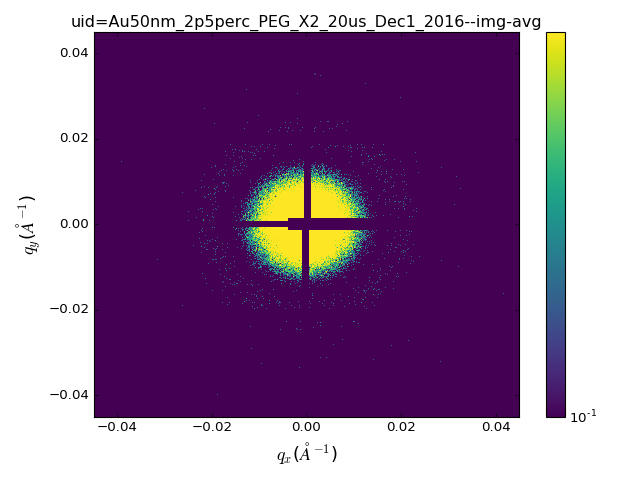

In [74]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= 'uid=%s--img-avg'%uid_average,  save=True) 

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


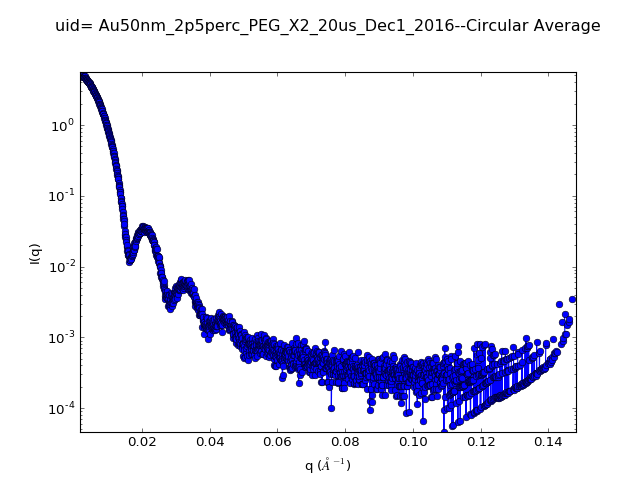

In [88]:
hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )

plot_circular_average( qp, iq, q,  pargs=setup_pargs, 
                      xlim=[q.min(), q.max()], ylim = [iq.min(), iq.max()] )


### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [34]:
uniformq = True #False

### Define a non-uniform distributed rings by giving edges

In [35]:
if not uniformq:    
    width = 0.0002    
    number_rings= 1    
    qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  qcenters, width, number_rings )    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [36]:
if uniformq:    
    inner_radius= 0.005 #0.005 for 50 nm, 0.006, #for 10nm/coralpor
    outer_radius = 0.04 #0.04 for 50 nm, 0.05, #for 10nm/coralpor 
    num_rings = 12
    gap_ring_number = 6
    width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
    edges = None

In [37]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 
q_ring_center = np.round( q_ring_center, 4)

<IPython.core.display.Javascript object>


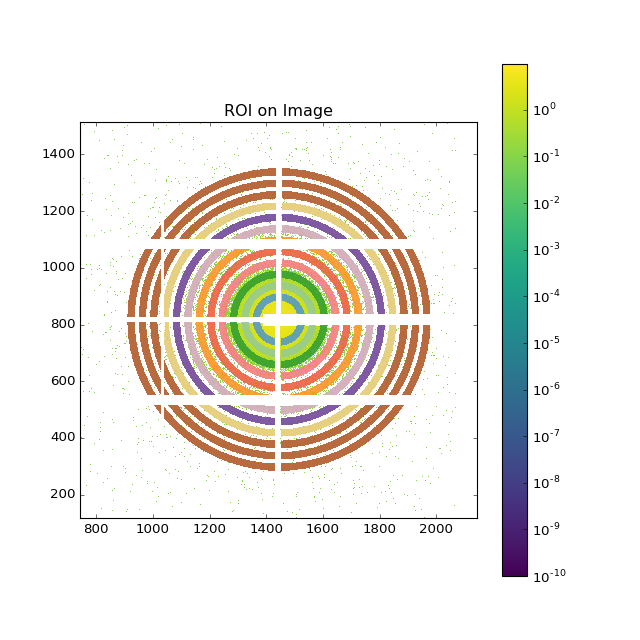

In [76]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir_average, uid=uid_average, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 

<IPython.core.display.Javascript object>


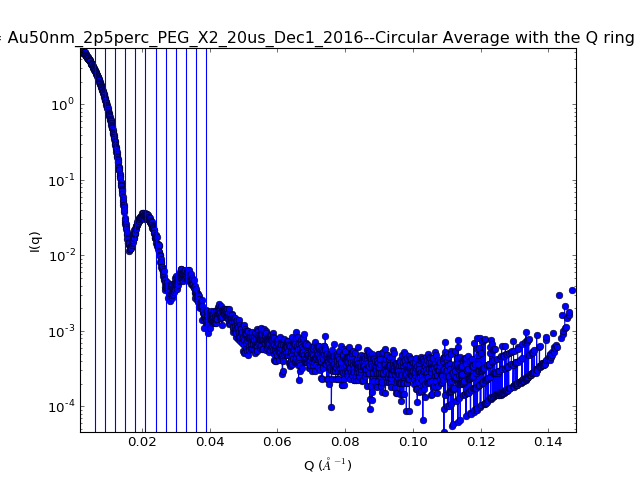

In [78]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid_average, xlim=[q.min(), q.max()],
                  ylim = [iq.min(), iq.max()],  save=True, path=data_dir_average)

# Configure Multi-Run

## Control Multi-Runs Parameters


In [79]:

run_pargs=  dict(   
    force_compress =  force_compress,    #force to compress data 
    para_compress = para_compress,             #parallel compress
    run_fit_form = run_fit_form,             #run fit form factor  
    run_waterfall = run_waterfall,             #run waterfall analysis
    run_t_ROI_Inten = run_t_ROI_Inten,          #run  ROI intensity as a function of time
    run_one_time = run_one_time,      #run  one-time
    fit_g2_func = fit_g2_func,    
    run_two_time = run_two_time,    #run  two-time
    run_four_time = run_four_time,     #run  four-time
    run_xsvs=run_xsvs,            #run visibility analysis
    att_pdf_report = att_pdf_report,       #attach the pdf report to CHX olog
    show_plot = False,
                 
    CYCLE =  CYCLE, mask_path =  mask_path, mask_name =    mask_name, 
    good_start   =  good_start,
    uniformq = uniformq,    inner_radius= inner_radius, 
    outer_radius =   outer_radius,    num_rings =num_rings,   gap_ring_number = gap_ring_number, 
    #number_rings= number_rings,    
    qth_interest =  qth_interest, #the intested single qth,            
    use_sqnorm = use_sqnorm,  #if True, use sq to normalize intensity
    use_imgsum_norm=use_imgsum_norm,#if True use imgsum to normalize intensity for one-time calculatoin
    pdf_version = pdf_version #for pdf report name    
                )


In [80]:
run_pargs

{'CYCLE': '2016_3',
 'att_pdf_report': True,
 'fit_g2_func': 'stretched',
 'force_compress': False,
 'gap_ring_number': 6,
 'good_start': 5,
 'inner_radius': 0.005,
 'mask_name': 'Nov28_4M_SAXS_mask.npy',
 'mask_path': '/XF11ID/analysis/2016_3/masks/',
 'num_rings': 12,
 'outer_radius': 0.04,
 'para_compress': True,
 'pdf_version': '_1',
 'qth_interest': 3,
 'run_fit_form': False,
 'run_four_time': True,
 'run_one_time': True,
 'run_t_ROI_Inten': True,
 'run_two_time': True,
 'run_waterfall': True,
 'run_xsvs': True,
 'show_plot': False,
 'uniformq': True,
 'use_imgsum_norm': True,
 'use_sqnorm': False}

In [ ]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter.py

In [ ]:
from chxanalys.chx_xpcs_xsvs_jupyter import run_xpcs_xsvs_single

# Do loop here

In [ ]:
multi_res = {}
t0 = time.time()
for uid in guids:
    multi_res[uid] = run_xpcs_xsvs_single( uid, run_pargs= run_pargs, return_res= True )
run_time(t0)    

### For Load results

In [21]:
#plt.close('all')
if True:#False:
    multi_res = {}
    for uid, fuid in zip(guids,fuids):
        multi_res[uid] =  extract_xpcs_results_from_h5( filename = '%s_Res.h5'%fuid, import_dir = data_dir + uid +'/' )

# Get and Plot Averaged Data

In [22]:
mkeys = list(multi_res.keys())
print(mkeys)
print( multi_res[mkeys[0]].keys())

['296b1ffa', 'ca87b48e', '25f88334', 'd2daceb0', '21af2295', '154de8eb', '772018fb', 'de453f7b', '89297ae8', '8862b3c7']
dict_keys(['contrast_factorL', 'tausb', 'md', 'times_xsvs', 'pixel_mask', 'g2b', 'avg_img', 'roi', 'spec_km_pds', 'spec_pds', 'g12b', 'g2', 'taus4', 'g2b_fit_paras', 'mask', 'g4', 'taus', 'g2_fit_paras'])


In [23]:
uid_average

'Au50nm_2p5perc_PEG_X2_20us_Dec1_2016'

In [24]:
data_dir_average

'/XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/'

In [44]:
if run_one_time:
    g2 = get_averaged_data_from_multi_res(  multi_res, keystr='g2' )
    taus = get_averaged_data_from_multi_res(  multi_res, keystr='taus' )
    
    data_dir_average    
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir_average, uid=uid_average ) 
    g2_pds = save_g2( g2, taus=taus, qr= q_ring_center, qz=None,
                     uid= uid_average +'--g2.csv', path= data_dir_average, return_res=True )
    
    g2_fit_result, taus_fit, g2_fit = get_g2_fit( g2,  res_pargs=res_pargs, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fit = dict(taus=taus_fit, q_ring_center= q_ring_center, path=data_dir,uid=uid  +'_g2_fit'       )
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  
                        filename= 'uid=%s'%uid_average  +'_g2_fit_paras.csv', path=data_dir_average ) 
    

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/ with filename as uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016--g2.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016_g2_fit_paras.csv


In [ ]:
if run_one_time:
    plot_g2( g2, res_pargs= res_pargs, tau_2 = taus_fit, g2_2 = g2_fit,  
        fit_res= g2_fit_result, function = fit_g2_func, master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name=  '-fit'  )    
    fit_q_rate(  q_ring_center[:],g2_fit_paras['relaxation_rate'], power_variable= False, 
           uid=uid_average  , path= data_dir_average)

In [26]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [42]:
if run_two_time:
    g12b = get_averaged_data_from_multi_res(  multi_res, keystr='g12b',different_length= True )
    g2b = get_averaged_data_from_multi_res(  multi_res, keystr='g2b' )
    tausb = get_averaged_data_from_multi_res(  multi_res, keystr='tausb' )

    res_pargsb = dict(taus=tausb, q_ring_center=q_ring_center,  uid=uid_average  , path= data_dir_average     )
    g2b_pds = save_g2( g2b, taus=tausb, qr= q_ring_center, qz=None, 
                       uid=uid_average +'--g2b.csv'  , path= data_dir_average, return_res=True )
    
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit( g2b,  res_pargs=res_pargsb, 
                function = 'stretched',  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fitb = dict(taus=taus_fitb, q_ring_center= q_ring_center,  
                         path=data_dir_average , uid=uid_average  +'_g2b_fit'       )
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= 'uid=%s'%uid_average  + '_g2b_fit_paras--g2.csv', path=data_dir_average )
    


The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/ with filename as uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016--g2b.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016_g2b_fit_paras--g2.csv


In [ ]:
if run_two_time:
    show_C12(g12b, q_ind= qth_interest, N1= 0, N2=min( len(imgsa) ,1000), vmin=1.01, vmax=1.25,
             timeperframe=timeperframe,save=True,
             path= data_dir_average, uid = uid_average )
    plot_g2( g2b, res_pargs= res_pargsb, tau_2 = taus_fitb, g2_2 = g2_fitb,  
        fit_res= g2_fit_resultb, function = fit_g2_func, master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name= '-b-fit'  )

In [ ]:
if run_two_time and run_one_time:
    #fit_q_rate(  q_ring_center[:],dfvb['relaxation_rate'], power_variable= False,  uid=uid +'-g2b' , path= data_dir )
    plot_saxs_two_g2( g2, taus, 
                 g2b, tausb, res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid_average  )

In [45]:
if run_four_time:
    g4 = get_averaged_data_from_multi_res(  multi_res, keystr='g4' )
    taus4 = get_averaged_data_from_multi_res(  multi_res, keystr='taus4' )
    res_pargs4 = dict(taus=taus4, q_ring_center=q_ring_center, path=data_dir_average, uid=uid_average     )     
    g4_pds = save_g2( g4, taus=taus4, qr= q_ring_center, qz=None, 
                     uid=uid_average +'--g4.csv', path= data_dir_average, return_res=True )
     


The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/ with filename as uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016--g4.csv


In [ ]:
if run_four_time:
    plot_saxs_g4( g4, taus4,  vlim=[0.95, 1.05], logx=True, res_pargs=res_pargs4) 

In [46]:
if run_xsvs:
    contrast_factorL = get_averaged_data_from_multi_res(  multi_res, keystr='contrast_factorL',different_length=False )
    times_xsvs = get_averaged_data_from_multi_res(  multi_res, keystr='times_xsvs',different_length=False )
    cont_pds = save_arrays( contrast_factorL, label= times_xsvs, filename = 'uid=%s--contrast_factorL.csv'%uid_average,
            path=data_dir_average,return_res=True )

The file: uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016--contrast_factorL.csv is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/


In [ ]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, q_ring_center, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_average,path = data_dir_average, legend_size=14)

In [ ]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, q_ring_center, 
                     vlim=[0.8,1.2], qth = None, uid=uid_average,path = data_dir_average, legend_size=14)

## Export Results to a h5 files

In [81]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = 'unknown' #bad_frame_list
md['avg_img'] = avg_img
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['beg'] = None #'unknown' #good_start
md['end'] = None #'unknown' #len( imgsa)
md['metadata_file'] = data_dir_average + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir_average + 'uid=%s-md'%uid_average ) #save the setup parameters
save_dict_csv( md,  data_dir_average + 'uid=%s-md.csv'%uid_average, 'w')

Exdt = {} 
Exdt['md']=md
Exdt['roi']= ring_mask;Exdt['avg_img'] = avg_img;Exdt['mask']=mask;Exdt['pixel_mask']=pixel_mask
if run_one_time:Exdt['taus']= taus;Exdt['g2']=g2;Exdt['g2_fit_paras']=g2_fit_paras
if run_two_time:Exdt['tausb']= tausb;Exdt['g2b']=g2b;Exdt['g12b']=g12b;Exdt['g2b_fit_paras']=g2b_fit_paras    
if run_four_time:Exdt['taus4']= taus4;Exdt['g4']=g4
if run_xsvs:
    Exdt['times_xsvs']= times_xsvs;Exdt['contrast_factorL']= contrast_factorL 
    #Exdt['spec_km_pds']=spec_km_pds;Exdt['spec_pds']=spec_pds;

In [82]:
export_xpcs_results_to_h5( uid_average + '_Res.h5', data_dir_average, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = uid_average + '_Res.h5', import_dir = data_dir_average )

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/ with filename as Au50nm_2p5perc_PEG_X2_20us_Dec1_2016_Res.h5


## Create PDF report for each uid

In [83]:
pdf_out_dir = data_dir
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid_average,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid_average,pdf_version)

In [84]:
data_dir_average

'/XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2p5perc_PEG_X2_20us_Dec1_2016/'

In [85]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

In [89]:
make_pdf_report( data_dir_average, uid_average, pdf_out_dir, pdf_filename, username, 
                    run_fit_form, run_one_time, run_two_time, run_four_time, run_xsvs
                   )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=Au50nm_2p5perc_PEG_X2_20us_Dec1_2016_1.pdf
****************************************


### Attach each g2 result to the corresponding olog entry

In [96]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= fuids[-1], text='Add XPCS Averaged Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Averaged Analysis PDF Report and with the attachments


# The End!